# Phase 3 Machine Learning Classification Project - Stroke Dataset

![brain-showing-stroke.jpeg](images/brain-showing-stroke.jpeg)

**Student name**: Jordana Tepper, Troy Hendrickson, Viktoria Szontagh  
**Student pace**: Full Time  
**Instructor name**: Joseph Mata  

In [154]:
#Basics
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

# Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve
%matplotlib inline
from sklearn.metrics import recall_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

## Data Understanding

The data that we use for our project comes from a dataset from Kaggle titled, 'Stroke Prediction Dataset'. This source is comprised of basic life and health information from various individuals - some who have had a stroke and many who have not - such as age, BMI, presence of heart disease, type of work, and martial status.

In [155]:
# Loading in the dataset
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [156]:
# Looking at the general information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are 5110 rows and 12 columns in the dataset with variables of the following Datatypes: int, object, and float.

The categorical columns (Datatype 'object') 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'.

Despite 'hypertension', 'heart_disease', and 'stroke' being type 'int', we know that these are actually categorical columns, as well.

Furthermore, there appears to be missing values in the 'bmi' column.

In [157]:
# Looking at basic metrics of the dataset (for the numerical columns)
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000



Insights about Outliers:
* There are outliers in the age column with a minimum value of 0.08 - indicating that this dataset includes children.
* There are outliers in the 'avg_glucose_level' column with a maximum of 271.74
* There are outliers in the 'bmi' column with a maximum of 97.6
   - A BMI of 97.6 is very rare in reality, so we will likely have to take care of some outliers in this column

In [158]:
# Looking at basic metrics of the dataset (for the categorical columns)
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


Insights:
* More females than males in the dataset
* The majority of the individuals in this dataset have been married
* Most of the individuals in this dataset work in a field categorized as 'private'
* Most of the individuals in this dataset live in an urban area
* The most prevalent value in 'smoking_status' is 'never smoked'

In [159]:
# Further investigation of the missing values
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

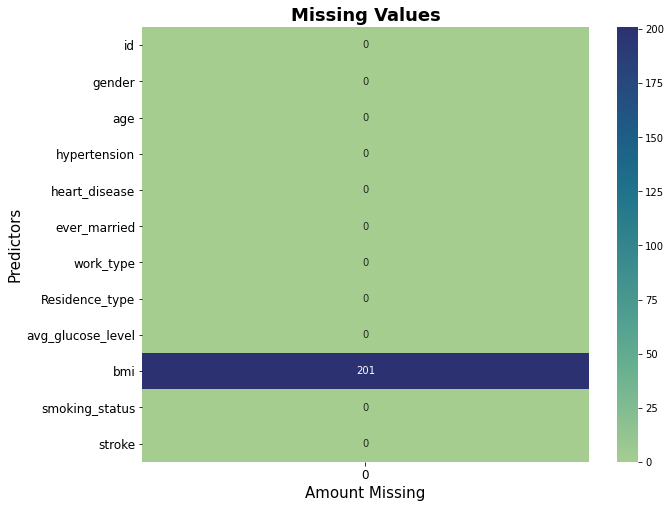

In [160]:
# Further investigation of the missing values
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='crest')
ax.set_xlabel('Amount Missing', fontdict = {'fontsize': 15})
ax.set_ylabel('Predictors', fontdict = {'fontsize': 15})
ax.set_title('Missing Values', fontweight='bold', fontdict = {'fontsize': 18})
plt.tick_params(axis='both', labelsize=12)
plt.show()

Based on information above, there are 201 missing values in the 'bmi' column and no missing values in the other columns.

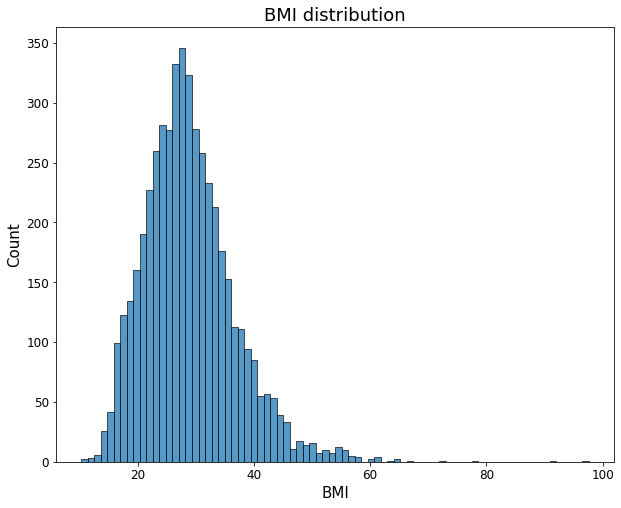

In [161]:
# Distribution of the 'bmi' column
fig ,ax = plt.subplots(figsize = (10,8))
sns.histplot(df['bmi'])
ax.set_title('BMI distribution', fontdict = {'fontsize': 18})
ax.set_xlabel('BMI', fontdict = {'fontsize': 15})
ax.set_ylabel('Count', fontdict = {'fontsize': 15})
plt.tick_params(axis='both', labelsize=12)
plt.show()

The 'bmi' column seems a little skewed to the right, so we will fill in the missing values with the median using Simple Imputer after we Train Test Split.

In [162]:
# Checking the value counts of the 'gender' column
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

There is only one line were the gender is 'other', so we will drop this row during our Data Preparation.

In [163]:
# Checking the value counts of the 'hyperstension' column
df['hypertension'].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

In [164]:
# Checking the value counts of the 'heart_disease' column
df['heart_disease'].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

In [165]:
# Checking the value counts of the 'ever_married' column
df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [166]:
# Checking the value counts of the 'work_type' column
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [167]:
# Checking the value counts of the 'Residence_type' column
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [168]:
# Checking the value counts of the 'smoking_status' column
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

There are 1544 indices in the dataset where the smoking status is 'Unknown'. This need to be further investigated.

In [169]:
# Checking the smoking status for 'unknown' and age below 13
df[(df['smoking_status'] == 'Unknown') & (df['age'] < 13)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
282,33759,Female,3.00,0,0,No,children,Urban,73.74,16.0,Unknown,0
291,11014,Male,4.00,0,0,No,children,Rural,79.17,20.0,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5078,27446,Female,8.00,0,0,No,children,Urban,76.31,15.5,Unknown,0
5079,42709,Male,1.72,0,0,No,children,Urban,77.28,17.1,Unknown,0
5089,56714,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
5095,68598,Male,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0


Based on the global statistic for smoking in children, we will later change the value in 'smoking_status' from 'Unknown' to 'never smoked' for those rows the where the age is below 13 years old.

In [170]:
# Distribution of stroke
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In most of the cases, 4861 indices, the patient had no history of a stroke. 

In 249 of the cases, the patient had a history of a stroke.


## Data Preparation

In [171]:
# Dropping 'id' since we will not be working with this column
df.drop('id', axis=1, inplace=True)

In [172]:
# Dropping the row with gender 'other'
df.drop(df[df.gender == 'Other'].index, inplace = True)

In [173]:
# Dropping the rows where BMI is greater than or equal to 50 as these values are extremely uncommon in reality
df = df.loc[(df['bmi']<50) | (df['bmi'].isna())]

In [174]:
# Reclassify those who are under 13 as never smoker
df.loc[((df['smoking_status'] == 'Unknown') & (df['age'] < 13)), 'smoking_status'] = 'never smoked'

In [175]:
# Checking to see if the code above worked
df['smoking_status'].value_counts()

never smoked       2406
Unknown             976
formerly smoked     871
smokes              777
Name: smoking_status, dtype: int64

Based on the values in the 'avg_glucose_level' column, we will assume that the glucose testing was done postprandial (after eating).

* A postprandial blood sugar level of less than 70 mg/dL indicates hypoglycemia.

* A postprandial blood sugar level of greater than or equal to 70 mg/dL and less than or equal to 140 mg/dL indicates normal glucose levels.

* A postprandial blood sugar level of greater than 140 mg/dL and less than or equal to 200 indicates pre-diabetes.

* A postprandial blood sugar level of greater than 200 indicates diabetes.

Below, we add a new column and categorize the data accordingly.

In [176]:
# Adding new column to categorize the glucose level
df.loc[df['avg_glucose_level'] < 70, 'blood_sugar_cat'] = 'hypoglycemia'
df.loc[(df['avg_glucose_level'] >= 70) & (df['avg_glucose_level'] <= 140), 'blood_sugar_cat'] = 'normal'
df.loc[(df['avg_glucose_level'] > 140) & (df['avg_glucose_level'] <= 200), 'blood_sugar_cat'] = 'pre-diabetic'
df.loc[df['avg_glucose_level'] > 200, 'blood_sugar_cat'] = 'diabetic'

## Data Analysis

### Distribution of ages among those who have had a stroke

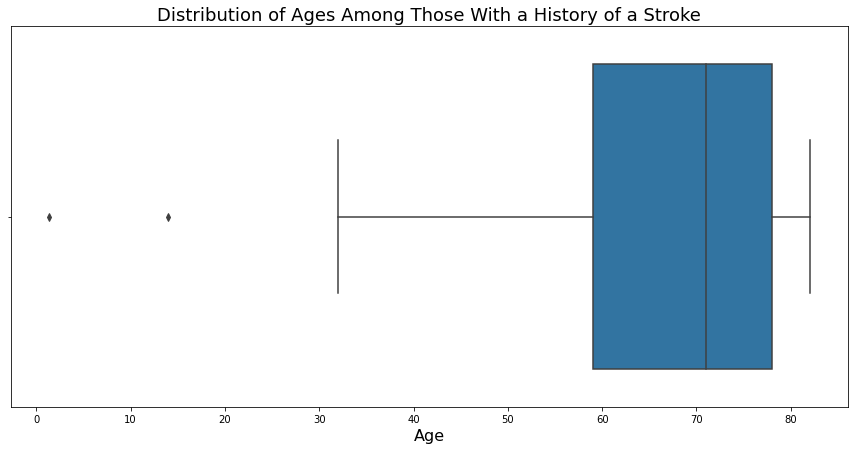

In [177]:
# Making a box plot to show the distributions of age for those who have had a stroke
stroke_yes = df.loc[df['stroke'] == 1]
fig, ax = plt.subplots(figsize = (15, 7))
fig = sns.boxplot(x=stroke_yes['age'])
ax.set_title('Distribution of Ages Among Those With a History of a Stroke', fontdict = { 'fontsize': 18});
ax.set_xlabel('Age', fontdict = { 'fontsize': 16});

### Distribution of BMI among those who have had a stroke

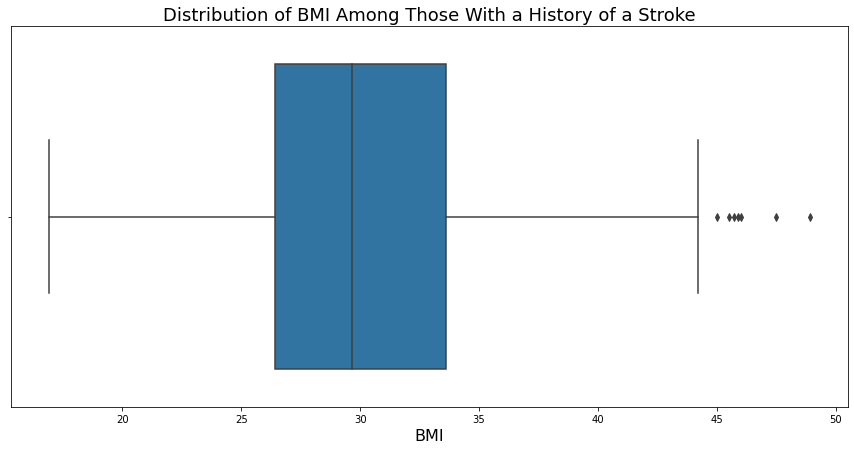

In [178]:
# Making a box plot to show the distributions of bmi for those who have had a stroke
fig, ax = plt.subplots(figsize = (15, 7))
fig = sns.boxplot(x=stroke_yes['bmi'])
ax.set_title('Distribution of BMI Among Those With a History of a Stroke', fontdict = { 'fontsize': 18});
ax.set_xlabel('BMI', fontdict = { 'fontsize': 16});

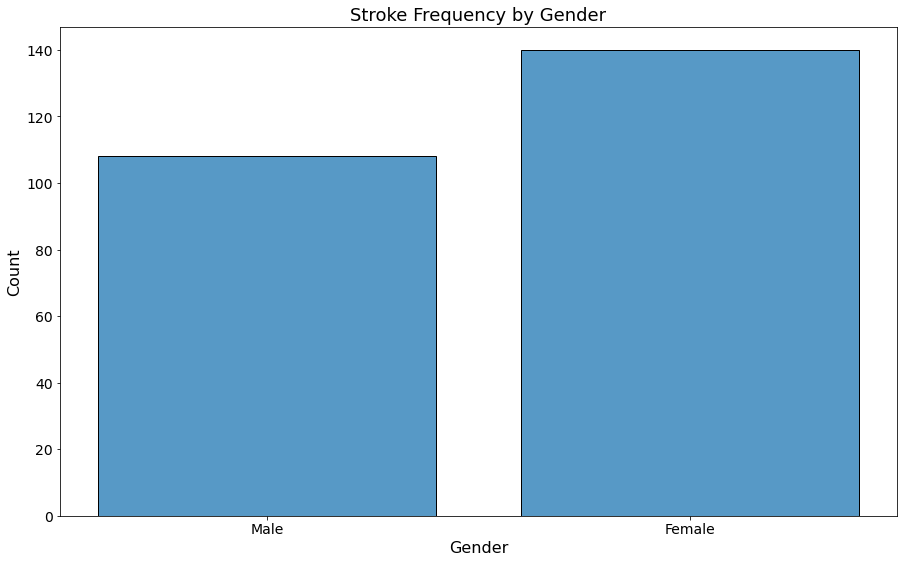

In [179]:
fig, ax = plt.subplots(figsize = (15, 9))
fig = sns.histplot(x=stroke_yes['gender'], shrink=0.8)
ax.set_title('Stroke Frequency by Gender', fontdict = {'fontsize': 18});
ax.set_xlabel('Gender', fontdict = { 'fontsize': 16});
ax.set_ylabel('Count', fontdict = { 'fontsize': 16});
plt.tick_params(axis='both', labelsize=14)

## Modeling

**Due to the fact that we are interested in using our model to detect stroke risk, a false negative is more costly than a false positive.**

**Therefore, the metric that matters most in our project is recall.**

In [180]:
# Train Test Split
X = df.drop(columns = 'stroke', axis = 1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 42)

In [181]:
# Simple imputer for missing bmi values 
bmi_imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_train['bmi'] = bmi_imp.fit_transform(X_train[['bmi']])
X_test['bmi'] = bmi_imp.transform(X_test[['bmi']])

In [182]:
# One Hot Encoding outside of the pipeline in order to use SMOTE for 
# the imbalanced data and avoid conflict in the pipeline
ohelist = ['gender', 'ever_married', 'work_type', 'Residence_type','smoking_status', 'blood_sugar_cat']
oheX_train = pd.get_dummies(X_train[ohelist])
oheX_test =  pd.get_dummies(X_test[ohelist])

# Joining the One Hot Encoded DataFrame with the original X_train and X_test
X_train = pd.concat([X_train, oheX_train], 1)
X_test = pd.concat([X_test, oheX_test], 1)

In [183]:
# Dropping the original categorical columns
X_train.drop(columns = ['gender', 'ever_married', 'work_type', 
                        'Residence_type','smoking_status', 'blood_sugar_cat'], inplace = True)
X_test.drop(columns = ['gender', 'ever_married', 'work_type', 
                       'Residence_type','smoking_status', 'blood_sugar_cat'], inplace = True)

In [184]:
# all_cols = X_train.columns
# norm_pipe = Pipeline([('norm_pipe', StandardScaler())])
# ct = ColumnTransformer(transformers = [('norm_pipe', norm_pipe, all_cols)])

### Model 1 (Baseline Model): Logistic Regression

In [191]:
# Creating the baseline pipeline
baseline_pipeline = Pipeline([('over', RandomOverSampler(sampling_strategy='minority', random_state = 42)),
                                ('scaler', StandardScaler()),
                                ('classifier', LogisticRegression(random_state=42))])

# We decided to use RandomOverSampler in the end as SMOTE was resulting in many issues within our model

In [192]:
# Fitting on the pipeline
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=42))])

In [193]:
# Calculating y_pred
y_pred = baseline_pipeline.predict(X_test)

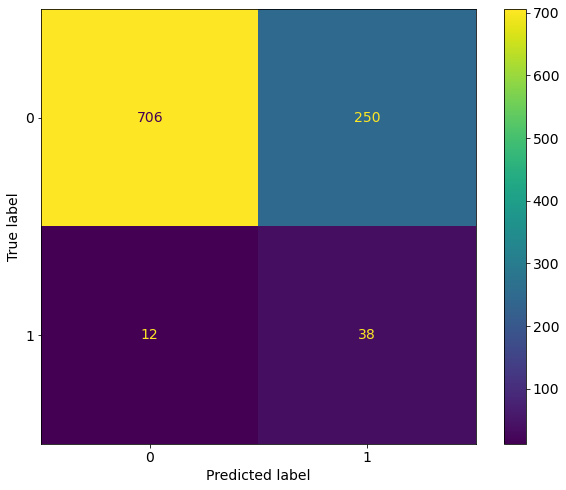

In [194]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
plot_confusion_matrix(baseline_pipeline, X_test, y_test, ax=ax);

In [195]:
# Calculating recall score
model1_recall = recall_score(y_test, y_pred)
model1_recall

print('Baseline Model Recall Score:', model1_recall)

Baseline Model Recall Score: 0.76


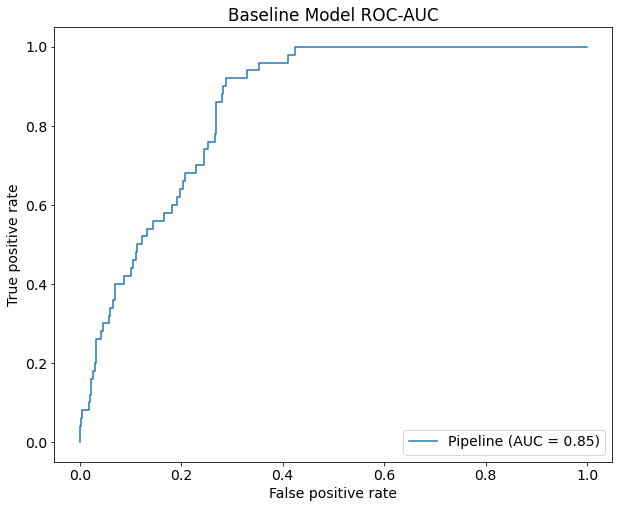

In [196]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(baseline_pipeline, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Baseline Model ROC-AUC')
plt.show()

A recall score of 0.76 is fine, but we want to see if we can increase the recall by finding the optimal threshold

In [201]:
# Calculating y probabilities
y_prob = baseline_pipeline.predict_proba(X_test)

In [202]:
# Using roc_curve() to find fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

In [203]:
# Creating a dataframe of fpr, tpr, and thresholds
thresh_df = pd.DataFrame({'threshold': thresholds,
                          'tpr':  tpr, 'fpr': fpr}).iloc[1::, :]

In [204]:
# Adding a column to the DataFrame called J_stat that represents Youden's J-statistic
thresh_df['J_stat'] = thresh_df['tpr'] - thresh_df['fpr']

In [205]:
# Selecting the threshold with highest J-statistic and labeling it the optimal threshold

max_selector = thresh_df.index == thresh_df['J_stat'].idxmax()

optimal_thresh = thresh_df[max_selector]
optimal_thresh

,threshold,tpr,fpr,J_stat
75,0.446014,0.92,0.288703,0.631297


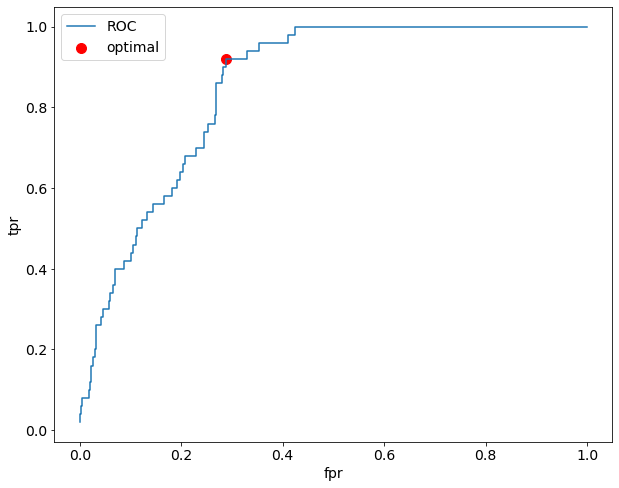

In [206]:
# Creating a visualization to mark the tpr and fpr values at the optimal threshold
fig, ax = plt.subplots(figsize = (10,8))
thresh_df.plot(x = 'fpr', y = 'tpr', ax = ax, label = 'ROC')
optimal_thresh.plot.scatter(x = 'fpr', y = 'tpr', c ='r', s = 100, ax = ax, label = 'optimal' )
plt.show()

In [207]:
# Calculating y predictions using the optimal threshold
thresh = optimal_thresh['threshold'].values
y_pred_best_threshold = (y_prob[:,1] >= thresh).astype(int)

In [208]:
# Finding the new recall value with the optimal threshold
model1_recall_opt = recall_score(y_test, y_pred_best_threshold)
model1_recall_opt

0.92

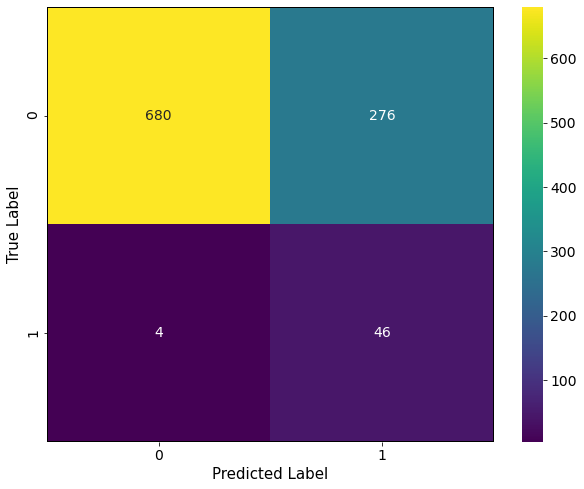

In [209]:
# Visualization a confusion matrix when using the optimal threshold
conf_mat_best = confusion_matrix(y_test, y_pred_best_threshold)
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(conf_mat_best, annot = True, fmt='g', annot_kws={'fontsize': 14}, 
            cmap = 'viridis', linecolor = 'black', ax = ax)
ax.set_ylabel('True Label', size = 15)
ax.set_xlabel('Predicted Label', size = 15)
ax.axhline(y = 0, color='k',linewidth = 1)
ax.axhline(y = conf_mat_best.shape[1], color = 'k',
            linewidth = 2)
ax.axvline(x = 0, color = 'k',
            linewidth = 1)
ax.axvline(x = conf_mat_best.shape[0], 
            color = 'k', linewidth = 2)
plt.show()

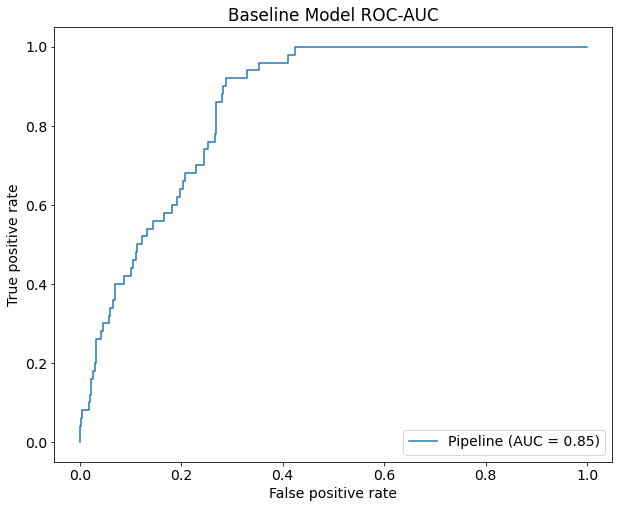

In [210]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(baseline_pipeline, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Baseline Model ROC-AUC')
plt.show()

### _Comments on Model 1 (Baseline Model)_

Overall, these results are good.

As mentioned earlier, for this project, the recall score is the most important as false negatives are more costly than false positives (i.e., classifying someone as not being at risk for a stroke when they are is worse than classifying someone as being at risk for a stroke when they are not). 

Before using the optimal threshold, our recall score was 0.76 which good, but not great. Furthermore, our false negative count was 12.

After finding the optimal threshold, the recall score increased to 0.92 with a false negative count of 4. 

We can better our recall score by further reducing the number of false negatives as well as examine other types of models.

The ROC-AUC score of 0.85 is good, but there may be room for improvement.

In our next models, we will attempt to maximize the recall score and minimize the number of false negatives value as much as possible. 

### Model 2: Decision Tree

In [211]:
# Define new model
model2_dt_pipe  = Pipeline([('over', RandomOverSampler(sampling_strategy='minority', random_state = 42)),
                        ('dt_clf', DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state = 42))])

In [212]:
# Fitting on the pipeline
model2_dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('dt_clf',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

In [213]:
# Calculating y_pred
y_pred = model2_dt_pipe.predict(X_test)

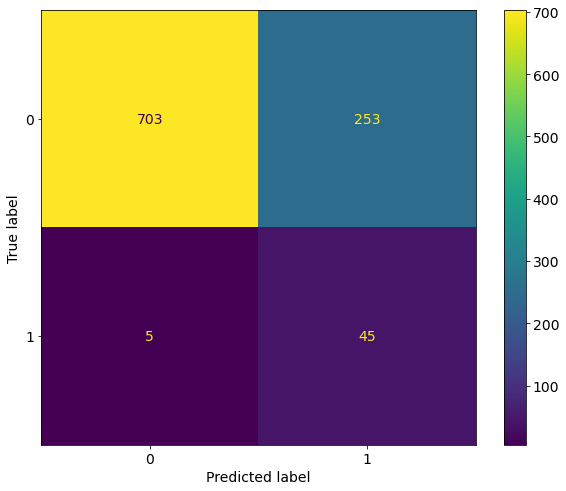

In [214]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
plot_confusion_matrix(model2_dt_pipe, X_test, y_test, ax=ax);

In [215]:
# Calculating recall score
model2_dt_recall = recall_score(y_test, y_pred)
model2_dt_recall

print('Second Model Recall Score:', model2_dt_recall)

Second Model Recall Score: 0.9


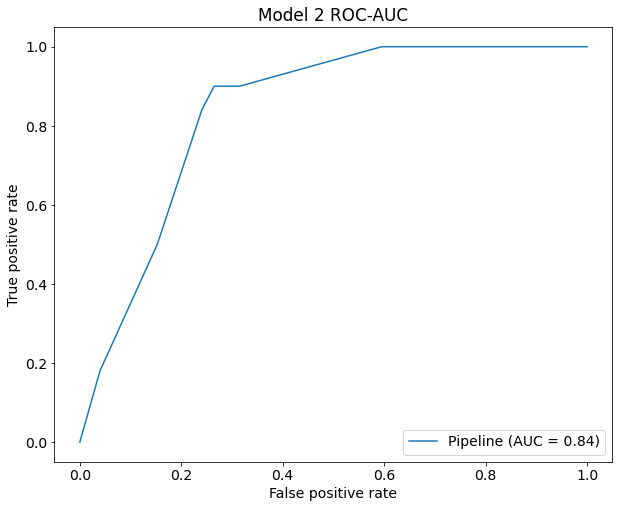

In [216]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(model2_dt_pipe, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 2 ROC-AUC')
plt.show()

### _Comments on Model 2_

The recall score for this model (0.90) is slightly worse than that of our baseline model (0.92). 

Furthermore, the AUC decreased by 0.01, but this is a trivial difference.

In our next models, we will tune our hyperparameters, and utilize a grid searches with cross validation.

### Model 3: K Nearest Neighbors

Since we have already done a Logistic Regression and Decision Tree, we decided to attempt a KNN model with a grid search and cross validation.

In [217]:
model3_knn_pipe  = Pipeline([('over', RandomOverSampler(sampling_strategy='minority', random_state = 42)),
                                ('scaler', StandardScaler()),
                                ('knn', KNeighborsClassifier())])


knn_params = {'knn__n_neighbors': [3, 5, 7, 9, 11, 13], 'knn__p': [1, 2, 3, 4, 5]}

In [218]:
knn_grid = GridSearchCV(estimator = model3_knn_pipe, param_grid = knn_params, scoring = 'recall', cv = 5)

In [219]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy='minority')),
                                       ('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13],
                         'knn__p': [1, 2, 3, 4, 5]},
             scoring='recall')

In [220]:
knn_grid.best_params_

{'knn__n_neighbors': 13, 'knn__p': 1}

In [221]:
model3_knn_pipe = Pipeline(steps = [['over', RandomOverSampler(sampling_strategy='minority', random_state = 42)],
                                       ['scaler', StandardScaler()],
                                       ['knn', KNeighborsClassifier(n_neighbors = 13, p = 1)]])
model3_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('scaler', StandardScaler()),
                ['knn', KNeighborsClassifier(n_neighbors=13, p=1)]])

In [222]:
y_pred_knn = model3_knn_pipe.predict(X_test)

In [223]:
model3_knn_recall = recall_score(y_test, y_pred_knn)
model3_knn_recall

0.4

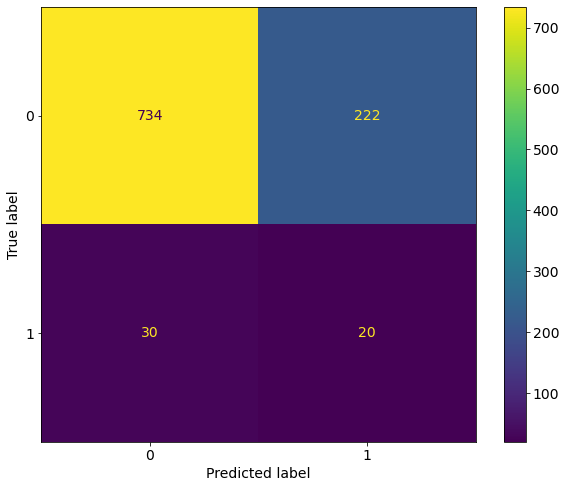

In [224]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
plot_confusion_matrix(model3_knn_pipe, X_test, y_test, ax=ax);

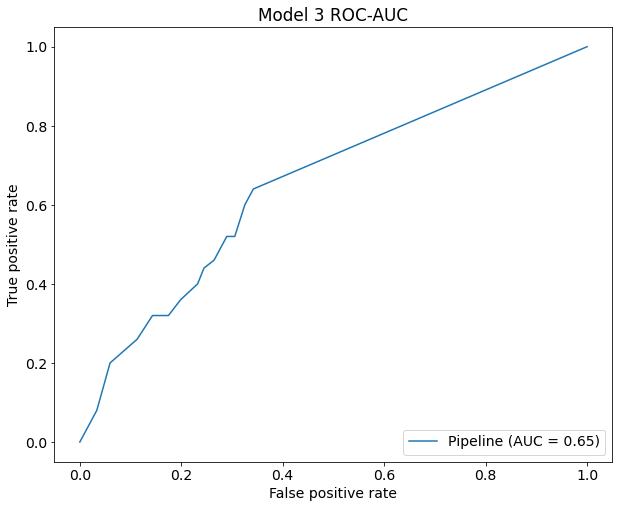

In [225]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(model3_knn_pipe, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 3 ROC-AUC')
plt.show()

### _Comments on Model 3_

The recall score for this model is 0.40 and the AUC is 0.65. 

Therefore, this model has been the worst by far.

### Model 4: Random Forest

Since the Decision Tree performed the best so far, we will utilize a Random Forest model to improve our results.

In [226]:
# Performing a grid search for our random forest
model4_rf_clf = Pipeline([('over', RandomOverSampler(sampling_strategy='minority', random_state = 42)), 
                                  ('forest', RandomForestClassifier(random_state = 42))])

rf_params = param_grid = {'forest__criterion': ['gini', 'entropy'], 
                          'forest__n_estimators': [50, 150, 200], 
                          'forest__min_samples_leaf': [2, 5, 20, 50],
                         'forest__max_depth': [3, 5, 7]}

rf_grid_pipeline = GridSearchCV(estimator = model4_rf_clf, param_grid = rf_params, scoring = 'recall', cv = 5)


rf_grid_pipeline.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy='minority')),
                                       ('forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest__criterion': ['gini', 'entropy'],
                         'forest__max_depth': [3, 5, 7],
                         'forest__min_samples_leaf': [2, 5, 20, 50],
                         'forest__n_estimators': [50, 150, 200]},
             scoring='recall')

In [227]:
rf_grid_pipeline.best_params_

{'forest__criterion': 'entropy',
 'forest__max_depth': 3,
 'forest__min_samples_leaf': 2,
 'forest__n_estimators': 50}

In [228]:
model4_rf_clf = Pipeline(steps = [['over', RandomOverSampler(sampling_strategy='minority', random_state = 42)],
                                   ['forest', RandomForestClassifier(random_state = 42, 
                                                              criterion = 'entropy',
                                                              max_depth = 3,
                                                              min_samples_leaf = 2,
                                                              n_estimators = 50
                                                              )]])
model4_rf_clf.fit(X_train, y_train)

Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ['forest',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=2, n_estimators=50,
                                        random_state=42)]])

In [229]:
y_rf_pred = model4_rf_clf.predict(X_test)

In [230]:
model4_rf_recall = recall_score(y_test, y_rf_pred)
model4_rf_recall

0.9

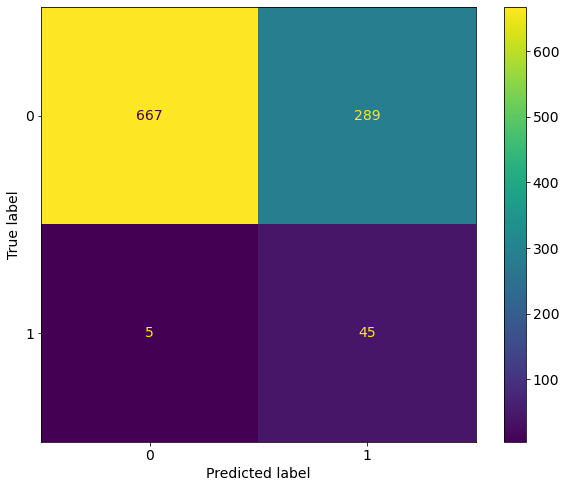

In [231]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
plot_confusion_matrix(model4_rf_clf, X_test, y_test, ax=ax);

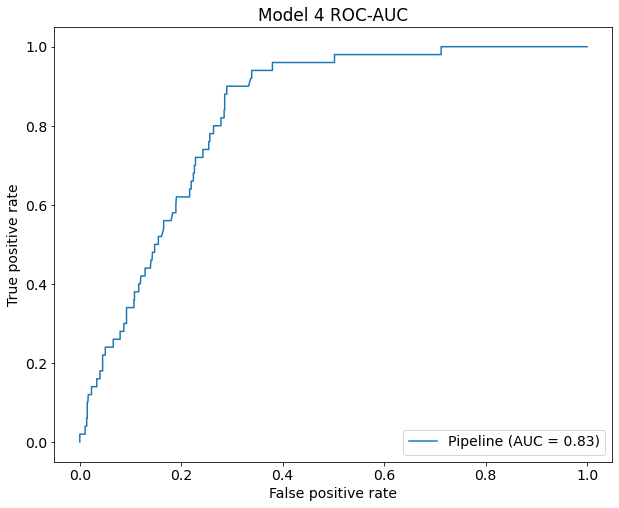

In [232]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(model4_rf_clf, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 4 ROC-AUC')
plt.show()

### _Comments on Model 4_

Our Random Forest resulted in a recall score of 0.90. This is the same recall score that we got when we used a Decision Tree (Model 2). Furthermore, there was a slight increase in false positives and a slight decrease in true negatives. 

The AUC also decreased by 0.01 compared to the AUC of Model 2.

Nevertheless, the Random Forest model performed very similarly to the Decision Tree.

Next, we will utilize XGBoost to see if this improves our results.

### Model 5: XGBoost

In [233]:
# Instantiate XGBClassifier

model5_xgb_clf = Pipeline(steps = [['over', RandomOverSampler(sampling_strategy='minority', random_state = 42)],
                                ['xgb', XGBClassifier(random_state = 42)]])

xgb_params = {
    'xgb__gamma': [0.5, 1, 5],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__n_estimators': [50, 100, 150, 200],
}

xgb_grid = GridSearchCV(estimator = model5_xgb_clf, param_grid = xgb_params, scoring = 'recall', cv = 5)

xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['over',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy='minority')],
                                       ['xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      ma...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None)]]),
             param_grid={'xgb__gamma': [0.5, 1, 5],
                         'xgb__learning_rate': [0.1, 0.2],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__min_child_weight': [1, 5, 10],
                         'xgb__n_estimators': [50, 100, 150, 200]},
             scoring='recall')

In [234]:
xgb_grid.best_params_

{'xgb__gamma': 0.5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 10,
 'xgb__n_estimators': 50}

In [235]:
model5_xgb_clf = Pipeline(steps = [['over', RandomOverSampler(sampling_strategy='minority', random_state = 42)],
                                ['scaler', StandardScaler()],
                                ['xgb', XGBClassifier(random_state = 42,
                                                     gamma = 0.5,
                                                     learning_rate = 0.1,
                                                     max_depth = 3,
                                                     min_child_weight = 10,
                                                     n_estimators = 50)]])
model5_xgb_clf.fit(X_train, y_train)

Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('scaler', StandardScaler()),
                ['xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0.5, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=10, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None)]])

In [236]:
y_xgb_pred = model5_xgb_clf.predict(X_test)

In [237]:
model5_xgb_recall = recall_score(y_test, y_xgb_pred)
model5_xgb_recall

0.7

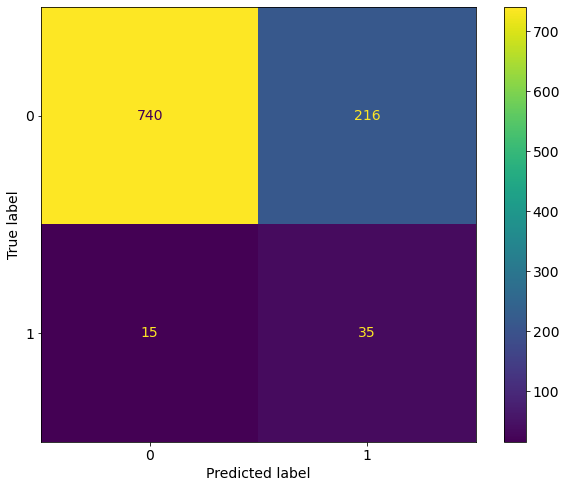

In [238]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
plot_confusion_matrix(model5_xgb_clf, X_test, y_test, ax=ax);

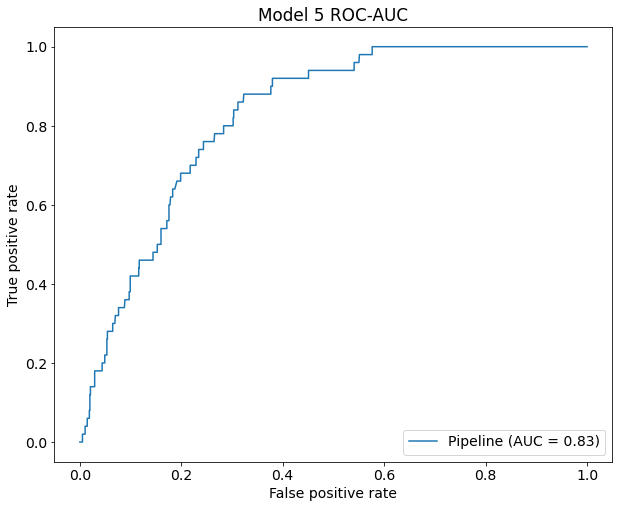

In [239]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(model5_xgb_clf, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 5 ROC-AUC')
plt.show()

### _Comments on Model 5_

Our XGBoost model did not perform as well as we had hoped. 

The model produced a recall score of 0.70, and an AUC of 0.83.

So far, this is one of the weaker models.

In our next model, we will use Gaussian Naive Bayes because it is a simple, effective, and fast classifier.

### Model 6: Gaussian Naive Bayes

In [240]:
model6_NB = Pipeline(steps = [['over', RandomOverSampler(sampling_strategy='minority', random_state = 42)],
                                ['nb', GaussianNB()]])


model6_NB.fit(X_train, y_train)

Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ['nb', GaussianNB()]])

In [241]:
y_pred = model6_NB.predict(X_test)

In [242]:
model6_NB_recall = recall_score(y_test, y_pred)
model6_NB_recall

0.94

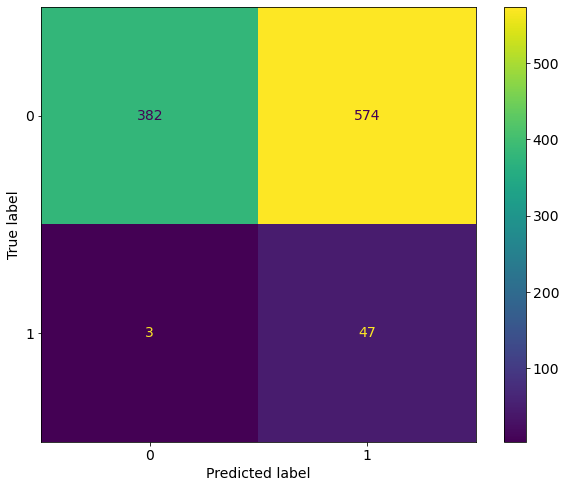

In [243]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
plot_confusion_matrix(model6_NB, X_test, y_test, ax=ax);

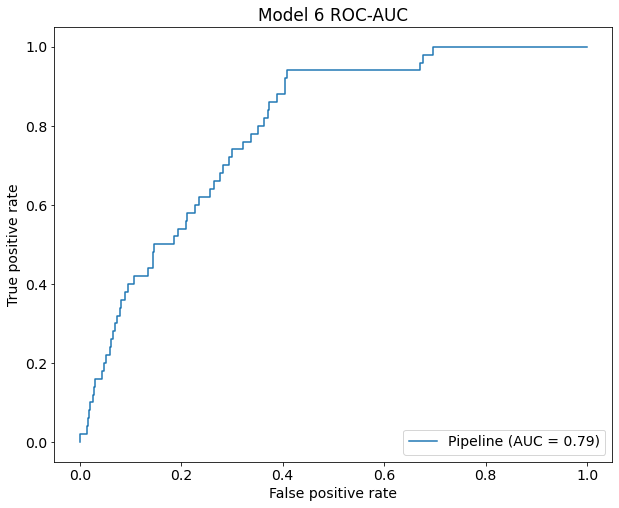

In [244]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(model6_NB, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 6 ROC-AUC')
plt.show()

### _Comments on Model 6_

Our Gaussian Naive Bayes model produced the best recall out of all the models with a score of 0.94.

However, this model also resulted in a false positive rate of 0.60 (as can be calculated with the confusion matrix).

## Evaluation of Our Final Model (Model 1  - Logistic Regression with the Optimal Threshold)

### Why did we chose the Logistic Regression model (recall of 92%) rather than the Gaussian Naive Bayes model (recall of 94%) as our final model?

Although our main priority of this project was to minimize recall, the false positive rate that came with our highest recall outcome was too high for comfort. More specifically, the model that had the best recall was our Gaussian Naive Bayes model with a recall score of 0.94 but a false positive rate of 0.60. In comparison, our Logistic Regression model with the optimal threshold had a recall score of 0.92 with a false positive rate of 0.29. 

Therefore, we decided that we are willing to risk a 0.02 difference in our recall for the sake of having a false positive rate that is more than half the size of that of the model with the best recall score. 

Since our model would be a preliminary screening, part of the logic behind this decision is that we would like to lower the likelihood of causing someone who tests positive for stroke risk but is not actually at such risk (false positive) to have to pay the unnecessary costs that would come with further screening.

### Revisiting the visualizations from our Logistic Regression Model with the Optimal Threshold

#### Confusion Matrix

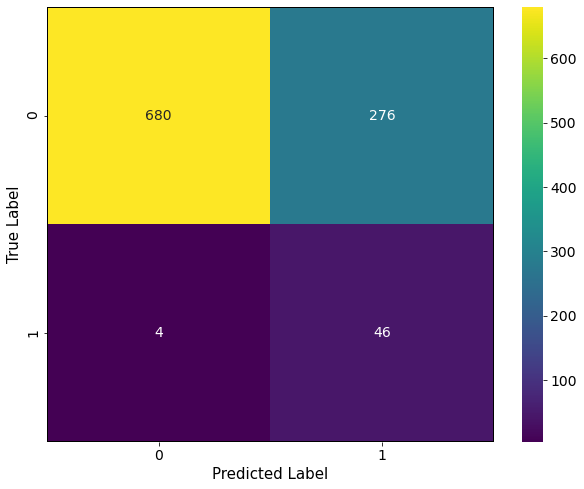

In [245]:
conf_mat_best = confusion_matrix(y_test, y_pred_best_threshold)
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(conf_mat_best, annot = True, fmt='g', annot_kws={'fontsize': 14}, 
            cmap = 'viridis', linecolor = 'black', ax = ax)
ax.set_ylabel('True Label', size = 15)
ax.set_xlabel('Predicted Label', size = 15)
ax.axhline(y = 0, color='k',linewidth = 1)
ax.axhline(y = conf_mat_best.shape[1], color = 'k',
            linewidth = 2)
ax.axvline(x = 0, color = 'k',
            linewidth = 1)
ax.axvline(x = conf_mat_best.shape[0], 
            color = 'k', linewidth = 2)
plt.show()

We have 4 false positives, 46 true positives, 276 false positives, and 680 true negatives from our testing set.

#### ROC-AUC (Area Under the Curve)

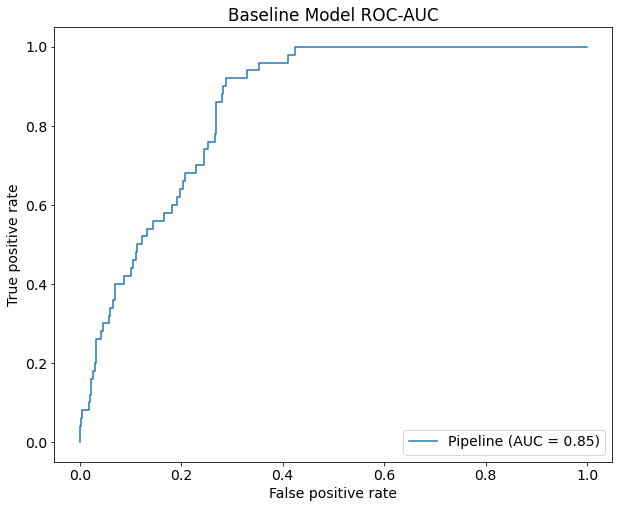

In [246]:
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(baseline_pipeline, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Baseline Model ROC-AUC')
plt.show()

The AUC is 0.85 which is good in terms of the goals of our project. In other words, we maximized the true positive rate (recall) as much as possible while also keeping our false positive rate at an acceptable level.

## Conclusions